In [22]:
import pandas as pd
import scipy.stats as stats
from utils import get_connection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [57]:
def extract_df(cursor, command):
    cursor.execute(command)
    res = cursor.fetchall()
    
    df = pd.DataFrame(res)
    df.columns = [x[0] for x in cursor.description]
    return df


def print_statistics(df, date=None):
    print(f'Statystyki opisowe dla {"dostępnych danych" if date is None else date}')
    print(df[['TEMPERATURE', 'HUMIDITY', 'PRESSURE', 'WINDSPEED']].describe())

In [66]:
connection = get_connection()
cursor = connection.cursor()

Statystyki dla całej bazy danych

In [67]:
df = extract_df(cursor, "SELECT W.MEASUREDATE, W.TEMPERATURE, W.APPARENTTEMPERATURE, W.HUMIDITY, W.PRECIPITATION, W.PRESSURE, W.CLOUDCOVER, W.WINDSPEED, C.CityName FROM Weather W JOIN Cities C ON W.CityID = C.CityID")
print_statistics(df)

Statystyki opisowe dla dostępnych danych
       TEMPERATURE     HUMIDITY     PRESSURE    WINDSPEED
count  8064.000000  8064.000000  8064.000000  8064.000000
mean     -2.039807    84.320809   994.468341    16.043155
std       4.975207     9.990278    16.442360     6.720768
min     -19.300000    38.000000   956.700000     0.000000
25%      -4.600000    79.000000   981.900000    10.900000
50%      -1.500000    87.000000   993.300000    15.900000
75%       0.900000    92.000000  1006.100000    20.600000
max      10.800000   100.000000  1036.500000    44.900000


Sprawdzenie statystyk dla konkretnego dnia

In [61]:
date = '2024-01-20'

string = (f"SELECT W.MEASUREDATE, W.TEMPERATURE, W.APPARENTTEMPERATURE, W.HUMIDITY, W.PRECIPITATION, W.PRESSURE, W.CLOUDCOVER, W.WINDSPEED, C.CityName "
          f"FROM Weather W JOIN Cities C ON W.CityID = C.CityID where trunc(W.MEASUREDATE) = DATE '{date}'")
print_statistics(extract_df(cursor, string))

Statystyki opisowe dla dostępnych danych
       TEMPERATURE    HUMIDITY     PRESSURE   WINDSPEED
count   384.000000  384.000000   384.000000  384.000000
mean     -0.917969   83.549479  1004.481771   22.527604
std       1.832080    7.278686     8.666748    6.514777
min      -5.700000   55.000000   988.800000    6.200000
25%      -2.300000   80.000000   997.700000   17.300000
50%      -0.850000   85.000000  1004.050000   22.350000
75%       0.525000   89.000000  1011.000000   26.900000
max       3.100000   97.000000  1025.300000   44.900000


Prognoza przewidywanych wartości temperatury

In [68]:
df

,MEASUREDATE,TEMPERATURE,APPARENTTEMPERATURE,HUMIDITY,PRECIPITATION,PRESSURE,CLOUDCOVER,WINDSPEED,CITYNAME
0,2024-01-01 00:00:00,4.5,1.3,86.0,0.0,992.9,91,9.6,Wroc?aw
1,2024-01-01 01:00:00,3.5,0.9,92.0,0.0,992.6,91,5.8,Wroc?aw
2,2024-01-01 02:00:00,4.1,1.2,89.0,0.1,993.0,94,8.1,Wroc?aw
3,2024-01-01 03:00:00,4.4,1.3,87.0,0.2,992.5,100,9.2,Wroc?aw
4,2024-01-01 04:00:00,4.2,0.8,85.0,0.0,992.6,93,10.7,Wroc?aw
...,...,...,...,...,...,...,...,...,...
8059,2024-01-21 19:00:00,1.6,-4.5,60.0,0.0,1017.1,100,22.7,Szczecin
8060,2024-01-21 20:00:00,2.1,-3.9,62.0,0.0,1016.3,100,22.9,Szczecin
8061,2024-01-21 21:00:00,2.2,-3.6,66.0,0.0,1016.1,100,22.1,Szczecin
8062,2024-01-21 22:00:00,2.1,-3.6,70.0,0.0,1015.2,100,22.3,Szczecin


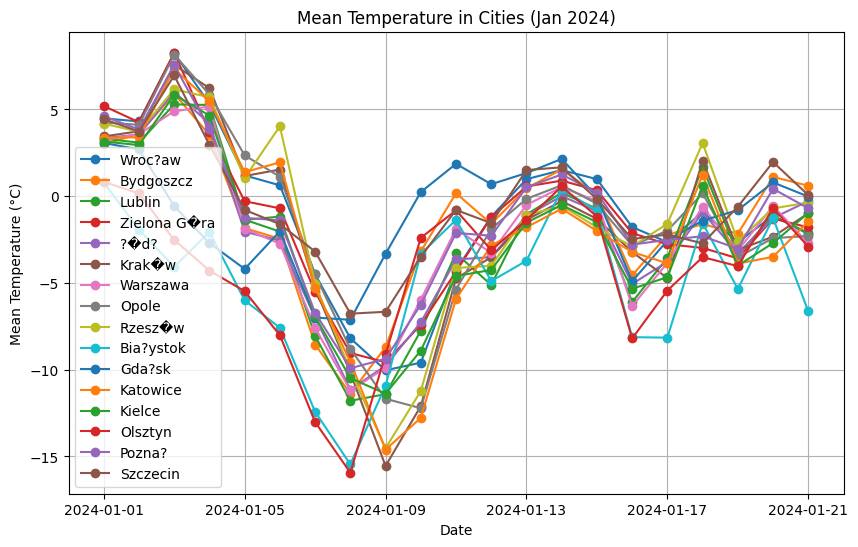

In [101]:
unique_cities = df['CITYNAME'].unique()

plt.figure(figsize=(10, 6))
for city_name in unique_cities:
    
    city = df[df['CITYNAME'] == city_name]
    mean_temperature_per_day = city.groupby(city['MEASUREDATE'].dt.date)['TEMPERATURE'].mean()

    plt.plot(mean_temperature_per_day.index, mean_temperature_per_day.values, marker='o', linestyle='-', label=city_name)

plt.title('Mean Temperature in Cities (Jan 2024)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()  # Add legend to show city names
plt.grid(True)
plt.show()

In [102]:
olsztyn = df[df['CITYNAME'] == 'Olsztyn']

X = olsztyn[['TEMPERATURE']]
y = olsztyn[['HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'CLOUDCOVER', 'WINDSPEED']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor()

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 263.02716405920256


ValueError: x and y must have same first dimension, but have shapes (504,) and (101, 5)

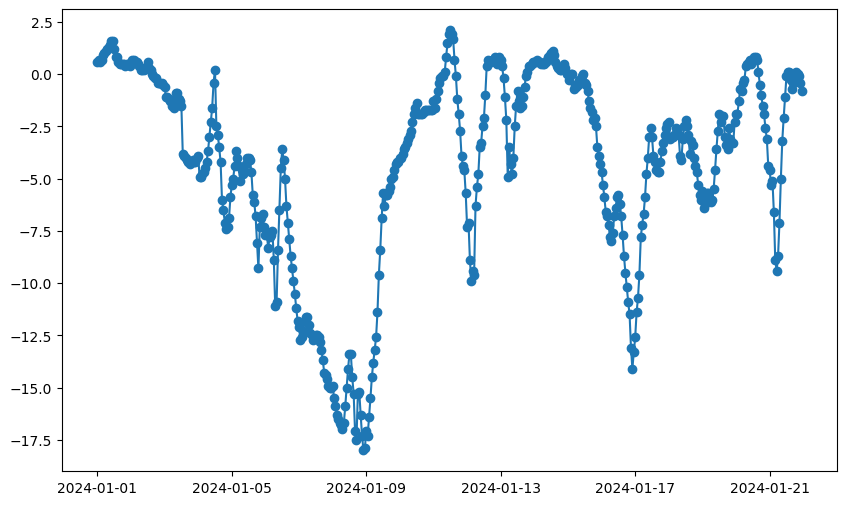

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(olsztyn['MEASUREDATE'], olsztyn['TEMPERATURE'], label='Actual Temperature', marker='o')
plt.plot(olsztyn.loc[len(olsztyn)-len(y_test):, 'MEASUREDATE'], y_pred, label='Random Forest Prediction', marker='o')
plt.title('Temperature Prediction using Random Forest Regression')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()